Imports

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind
import matplotlib.gridspec as gridspec

colors = np.array([(5,142,63),(4,119,59),(3,96,22),(3,68,12),(46,0,20)])/255

Import and sort data

In [87]:
df = pd.read_csv("Data/AVRIL 25 - Prélèvement du 10_04.csv")

#Conversion to float
str_to_float = ["Masse 1ère pesée (g)", "Masse 2ème pesée (g)", "Epaisseur (um)"]
for col in str_to_float:
    df[col] = df[col].str.replace(',', '.').astype(float)

# Relative deviation between the two weights
df['Écart relatif (%)'] = abs(df['Masse 2ème pesée (g)'] - df['Masse 1ère pesée (g)']) / df['Masse 1ère pesée (g)'] * 100
# SLA
taille_disque = 1.077 #en cm²
df['SLA'] =  df['Nombre de disque']*taille_disque/df['Masse 2ème pesée (g)']
# Sort by station
df["Station"] = ["Rhizo Haut"] * 8 + ["Rhizo Bas"] * 8



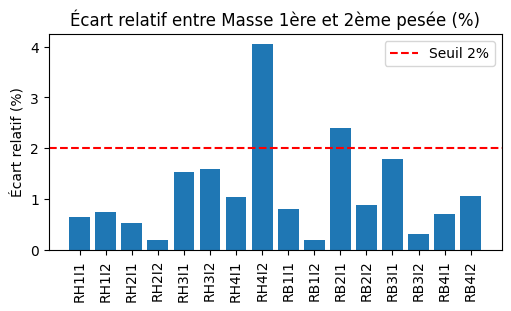

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5,3), constrained_layout=True)

#Plot écart relatif pour vérifier l'évolution de la masse entre la 1ère et la 2ème pesée
ax.bar(df['Individu'], df['Écart relatif (%)'])
ax.set_title("Écart relatif entre Masse 1ère et 2ème pesée (%)")
ax.set_ylabel("Écart relatif (%)")
ax.tick_params(axis='x', rotation=90)
ax.axhline(y=2, color='red', linestyle='--', label='Seuil 2%')
ax.legend()


Compute and plot SLA distribution 

C:\Users\arthu\AppData\Local\Temp\ipykernel_12360\3393102083.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[~g.index.isin([g['SLA'].idxmax(), g['SLA'].idxmin()])])


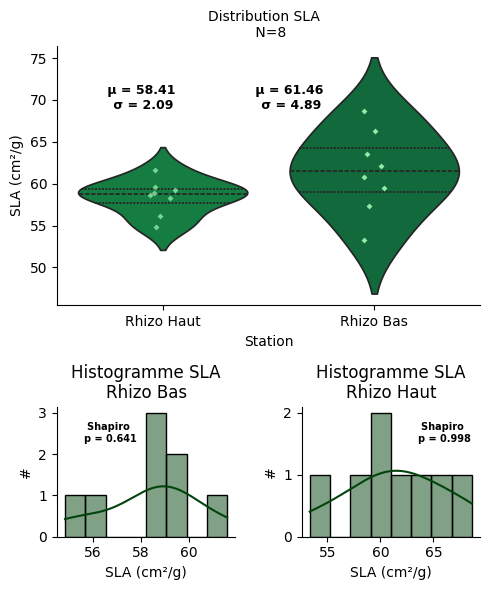

In [94]:
#Data for violin plot
df_violin = df[['Station', 'SLA']].copy()
df_violin_clean = (
    df_violin
    .groupby("Station", group_keys=False)
    .apply(lambda g: g.loc[~g.index.isin([g['SLA'].idxmax(), g['SLA'].idxmin()])])
    .reset_index(drop=True)
)
rhizo_haut = df_violin[df_violin['Station']=='Rhizo Haut']['SLA']
rhizo_bas = df_violin[df_violin['Station']=='Rhizo Bas']['SLA']

# Compute mean and std for each station 
mean_haut, std_haut = rhizo_haut.mean(), rhizo_haut.std()
mean_bas, std_bas = rhizo_bas.mean(), rhizo_bas.std()
#Compute p-value for Shapiro-Wilk test
shap_haut_p = shapiro(rhizo_haut).pvalue
shap_bas_p = shapiro(rhizo_bas).pvalue


# Violin plot

fig = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])  
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

color_marker = (163/255,247/255,181/255)  
station_order = ['Rhizo Haut', 'Rhizo Bas']

sns.violinplot(
    data=df_violin,
    x='Station',
    y= 'SLA',
    hue='Station',
    ax=ax0,
    inner="quart",
    palette=[colors[0], colors[1]], 
    order=station_order
)

sns.stripplot(
    data=df_violin[df_violin["Station"] == 'Rhizo Haut'],
    x='Station',
    y='SLA',
    ax=ax0,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.7,
    jitter=0.07,
    order=station_order
)

sns.stripplot(
    data=df_violin[df_violin["Station"] == 'Rhizo Bas'],
    x='Station',
    y='SLA',
    ax=ax0,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.9,
    jitter=0.07,
    order=station_order
)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.set_title("Distribution SLA  \n N=8", fontsize=10)
ax0.set_ylabel("SLA (cm²/g)")
ax0.text(0.2, 0.8, f" µ = {mean_haut:.2f} \n σ = {std_haut:.2f}",ha='center', va='center', transform=ax0.transAxes, fontsize=9, fontweight='bold')
ax0.text(0.55, 0.8, f" µ = {mean_bas:.2f} \n σ = {std_bas:.2f}",ha='center', va='center', transform=ax0.transAxes, fontsize=9, fontweight='bold')

# Single histogram for each station

sns.histplot(df_violin[df_violin["Station"] == "Rhizo Haut"]["SLA"],ax=ax1, kde=True, bins=8, color=colors[3])
ax1.set_title("Histogramme SLA\nRhizo Bas")
ax1.set_xlabel("SLA (cm²/g)")
ax1.set_ylabel("#")
ax1.text(0.3, 0.8, f"Shapiro \np = {shapiro(df_violin[df_violin["Station"] == "Rhizo Haut"]["SLA"]).pvalue:.3f}",ha='center', va='center', transform=ax1.transAxes, fontsize=7, fontweight='bold')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


sns.histplot(df_violin[df_violin["Station"] == "Rhizo Bas"]["SLA"],ax=ax2, kde=True, bins=8, color=colors[3])
ax2.set_title("Histogramme SLA\nRhizo Haut")
ax2.set_xlabel("SLA (cm²/g)")
ax2.set_ylabel("#")
ax2.text(0.8, 0.8, f"Shapiro \np = {shapiro(df_violin[df_violin["Station"] == "Rhizo Bas"]["SLA"]).pvalue:.3f}",ha='center', va='center', transform=ax2.transAxes, fontsize=7, fontweight='bold')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('Plot/SLA_1erCampagne.pdf',dpi=600)


Perform a t-test 

In [78]:
t_stat, p_val = ttest_ind(rhizo_bas, rhizo_haut, equal_var=False)  # Welch’s t-test
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")


T-statistic: 1.619, p-value: 0.138
